In [ ]:
# pip install plotly
# !pip install -U kaleido

## *Importing the required libraries**

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import os ,sys
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
target_dir = os.path.abspath(os.path.join(os.getcwd(), '..' ))
sys.path.append(target_dir)

from Models.RNNLSTMTensorFlow.Model import build_lstm_model ,train_model
from Models.RNNLSTMTensorFlow.inference import forecast
from Models.RNNLSTMTensorFlow.preprocessing import  create_dataset ,preprocess_data
from Models.RNNLSTMTensorFlow.plot import * 
from Models.RNNLSTMTensorFlow.evaluation import *
import gc
from Models.RNNLSTMTensorFlow.plot import plot_visualization
from Models.RNNLSTMTensorFlow.inference import forecast

import pandas as pd
import numpy as np


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## *Reading the Data**

In [39]:
daily_traffic_accident_data_path = '../data/processed/daily_data.csv'
daily_accident_df = pd.read_csv(daily_traffic_accident_data_path)
daily_accident_df

,daily,daily_accident
0,2018-01-01,234
1,2018-01-02,408
2,2018-01-03,231
3,2018-01-04,225
4,2018-01-05,342
...,...,...
1821,2022-12-27,183
1822,2022-12-28,177
1823,2022-12-29,191
1824,2022-12-30,193


## *Feature Engineering of the data*

In [36]:

time_series_data = daily_accident_df['daily_accident'].values

# Preprocess the data
scaled_data, scaler = preprocess_data(time_series_data)

time_steps = 10
future_step = 10
# Create the dataset
X, y = create_dataset(scaled_data, time_steps,future_step)


## *Spliting data into train ,validation and testing*

In [37]:

# Split the data into training and testing sets
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Further split training data into training and validation sets
split_index = int(len(X_train) * 0.8)
X_train, X_val = X_train[:split_index], X_train[split_index:]
y_train, y_val = y_train[:split_index], y_train[split_index:]

# Reshape the data for LSTM input
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


# Print the shapes
print("X_train shape:", X_train.shape)
print('y train shape : ',y_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)

X_train shape: (1155, 10, 1)
y train shape :  (1155, 10)
X_val shape: (289, 10, 1)
X_test shape: (362, 10, 1)


## *Training the Model*

In [45]:
parent_dir_for_saving_model = os.path.join("..","pkl_tensorflow")
os.makedirs(parent_dir_for_saving_model,exist_ok=True)

units = 64
epochs = 100
batch_size = 32
output_steps = future_step

list_of_trained_best_models = os.listdir(parent_dir_for_saving_model)
model_config = f"units_{units}_batch_size_{batch_size}_epochs_{epochs}_output_steps_{output_steps}"
model_name = f"{parent_dir_for_saving_model}/{model_config}"

if model_config in list_of_trained_best_models:
    print('Loading already trained Model')
    model = tf.keras.models.load_model(model_name)
else:
    print('Training Fresh Model')
    model = build_lstm_model((X_train.shape[1], 1), units,output_steps)
    history = train_model(model, X_train, y_train, X_val, y_val, epochs, batch_size)
    
    model.save(model_name)



Training Fresh Model
Epoch 1/100
37/37 [==============================] - 4s 26ms/step - loss: 0.1670 - val_loss: 0.1068
Epoch 2/100
37/37 [==============================] - 0s 7ms/step - loss: 0.1177 - val_loss: 0.1042
Epoch 3/100
37/37 [==============================] - 0s 7ms/step - loss: 0.1170 - val_loss: 0.1040
Epoch 4/100
37/37 [==============================] - 0s 7ms/step - loss: 0.1171 - val_loss: 0.1038
Epoch 5/100
37/37 [==============================] - 0s 7ms/step - loss: 0.1170 - val_loss: 0.1041
Epoch 6/100
37/37 [==============================] - 0s 7ms/step - loss: 0.1171 - val_loss: 0.1041
Epoch 7/100
37/37 [==============================] - 0s 7ms/step - loss: 0.1171 - val_loss: 0.1040
Epoch 8/100
37/37 [==============================] - 0s 7ms/step - loss: 0.1170 - val_loss: 0.1040
Epoch 9/100
37/37 [==============================] - 0s 7ms/step - loss: 0.1170 - val_loss: 0.1039
Epoch 10/100
37/37 [==============================] - 0s 7ms/step - loss: 0.1170 - val_

INFO:tensorflow:Assets written to: ../pkl_tensorflow/units_64_batch_size_32_epochs_100_output_steps_10/assets


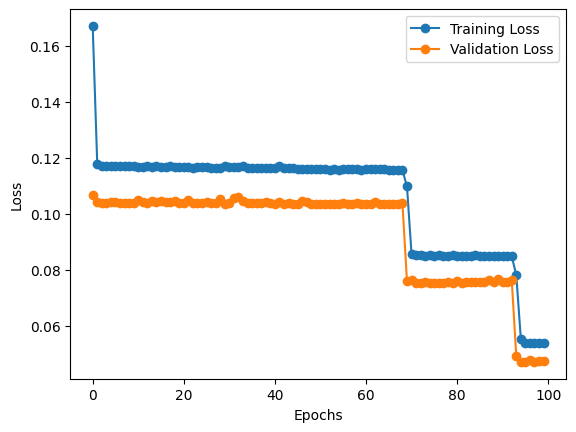

In [46]:
# Plot training loss and validation loss
plt.plot(model.history.history['loss'], label='Training Loss',marker='o')
plt.plot(model.history.history['val_loss'], label='Validation Loss',marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [47]:

print('[INFO] Evaluation of RNN-LSTM Model')

test_data_df = daily_accident_df.iloc[split_index:,:]
time_axis ,test_data = test_data_df['daily'].values ,test_data_df['daily_accident'].values
# scaled_test_data = scaler.fit_transform(test_data.reshape(-1,1))


# Example usage
# transformer_ob = transformer_object  # Assuming this is defined elsewhere
evaluation_rnn_lstm_df = evaluation_of_model_RnnLstm_Model(model_name,
                                                transformer_ob=scaler,
                                                ts_test=test_data,
                                                ts_train=test_data,
                                                time_axis=time_axis)
gc.collect()


[INFO] Evaluation of RNN-LSTM Model
window_size :60
Horzan : 611
Evaluation of input window : 60 & Horizon : 611
1/1 [==============================] - 0s 20ms/step
Mini lenght is : 610
forecasted_series :  610
actual_val :  610
actual_val_time_axis :  610


window_size :120
Horzan : 551
Evaluation of input window : 120 & Horizon : 551
1/1 [==============================] - 0s 21ms/step
Mini lenght is : 551
forecasted_series :  551
actual_val :  551
actual_val_time_axis :  551


window_size :180
Horzan : 491
Evaluation of input window : 180 & Horizon : 491
1/1 [==============================] - 0s 22ms/step
Mini lenght is : 491
forecasted_series :  491
actual_val :  491
actual_val_time_axis :  491


window_size :240
Horzan : 431
Evaluation of input window : 240 & Horizon : 431
1/1 [==============================] - 0s 29ms/step
Mini lenght is : 431
forecasted_series :  431
actual_val :  431
actual_val_time_axis :  431


window_size :300
Horzan : 371
Evaluation of input window : 300 & Horizon : 371
1/1 [==============================] - 0s 24ms/step
Mini lenght is : 371
forecasted_series :  371
actual_val :  371
actual_val_time_axis :  371


115761

In [48]:
evaluation_rnn_lstm_df

,input_window_in_hours,output_window_in_hours,MAE,RMSE,MAPE,MSE
0,60,611,70.61,100.43,27.52,10086.25
1,120,551,70.49,99.99,27.58,9997.49
2,180,491,70.71,100.28,27.46,10056.35
3,240,431,70.85,100.60,27.42,10120.21
4,300,371,68.95,99.39,25.90,9877.99
